In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, confusion_matrix
from xgboost import XGBRegressor
from xgboost import plot_importance
# from sklearn.grid_search import GridSearchCV

In [6]:
# Preprocessing data and helpers
number = re.compile('[\d,]+')
def get_first_number(val):
    matched = number.match(str(val))
    if matched:
        return int(matched.group().replace(',', ''))
    else:
        return np.nan

def dict_map(dict_to_use):
    def mapper(val):
        if val in dict_to_use:
            return dict_to_use[val]
        else:
            return np.nan

    return mapper

def split_list(list_str):
    return np.core.defchararray.split(list_str, sep='; ')

def userlist_to_cols(col):
    list_elems = col.astype(np.str).apply(split_list)
    categories = set(chain.from_iterable(list_elems.values))
    categories.discard('nan')
    categories = pd.Series(list(categories))
    
    def category_to_cols(category):
        return list_elems.map(lambda user_resp: category in user_resp)\
                         .rename('%s_%s' % (col.name, category))\
                         .astype('int8')
    
    new_cols = categories.map(category_to_cols)
    return pd.concat(new_cols.values, axis=1)

listvals = [
    'self_identification',
    'tech_do',
    'tech_want',
    'dev_environment',
    'education',
    'new_job_value',
    'how_to_improve_interview_process',
    'developer_challenges',
    'why_stack_overflow',
]

number_parses = [
    'company_size_range',
    'team_size_range',
    'women_on_team',
    'hobby',
    'rep_range',
    'interview_likelihood',
]

to_drop = [
    'age_range',
    'experience_range',
    'salary_range',
]

satisfaction_strs = {
    'I love my job': 10,
    'I\'m somewhat satisfied with my job': 7.5,
    'I\'m neither satisfied nor dissatisfied with my job': 5,
    'I\'m somewhat dissatisfied with my job': 2.5,
    'I hate my job': 0,
}

agree_strs = {
    'Agree completely': 5,
    'Agree somewhat': 4,
    'Neutral': 3,
    'Disagree somewhat': 2,
    'Disagree completely': 1,
}

important_strs = {
    'This is very important': 3,
    'This is somewhat important': 2,
    'I don\'t care about this': 1,
}

In [7]:
# 2016 preproc
data = pd.read_csv('data/2016.csv')
data['job_satisfaction'] = data['job_satisfaction']\
                                    .map(satisfaction_strs).astype('float')
data = data[data['job_satisfaction'].notnull()]

data['gender_M'] = (data['gender'] == 'Male').astype('int8')
data['gender_F'] = (data['gender'] == 'Female').astype('int8')
to_drop.append('gender')

to_drop.extend(listvals)
for index in listvals:
    data = pd.concat([data, userlist_to_cols(data[index])], axis=1)

data[number_parses] = data[number_parses].applymap(get_first_number).astype('float')

agree_keys = [index for index in data if 'agree_' in index]
data[agree_keys] = data[agree_keys].applymap(dict_map(agree_strs))

important_keys = [index for index in data if 'important_' in index]
data[important_keys] = data[important_keys].applymap(dict_map(important_strs))

data.drop(to_drop, axis=1, inplace=True)
data = pd.get_dummies(data)

print ('Columns with NaNs:')
for key in data:
    if data[key].isnull().any():
        print (key)
data.fillna(data.mean(), inplace=True)
print ('Filling with mean of column')

Columns with NaNs:
age_midpoint
experience_midpoint
salary_midpoint
big_mac_index
programming_ability
company_size_range
team_size_range
women_on_team
hobby
rep_range
interview_likelihood
agree_tech
agree_notice
agree_problemsolving
agree_diversity
agree_adblocker
agree_alcohol
agree_loveboss
agree_nightcode
agree_legacy
agree_mars
important_variety
important_control
important_sameend
important_newtech
important_buildnew
important_buildexisting
important_promotion
important_companymission
important_wfh
important_ownoffice
Filling with mean of column


In [8]:
data = data.drop(['Unnamed: 0'], axis=1)

In [9]:
list(data)

['age_midpoint',
 'experience_midpoint',
 'salary_midpoint',
 'big_mac_index',
 'programming_ability',
 'company_size_range',
 'team_size_range',
 'women_on_team',
 'job_satisfaction',
 'hobby',
 'rep_range',
 'interview_likelihood',
 'agree_tech',
 'agree_notice',
 'agree_problemsolving',
 'agree_diversity',
 'agree_adblocker',
 'agree_alcohol',
 'agree_loveboss',
 'agree_nightcode',
 'agree_legacy',
 'agree_mars',
 'important_variety',
 'important_control',
 'important_sameend',
 'important_newtech',
 'important_buildnew',
 'important_buildexisting',
 'important_promotion',
 'important_companymission',
 'important_wfh',
 'important_ownoffice',
 'gender_M',
 'gender_F',
 'self_identification_Manager',
 'self_identification_Full Stack Overflow Developer',
 'self_identification_Engineer',
 'self_identification_Developer',
 'self_identification_Full-stack Developer',
 'self_identification_Hacker',
 'self_identification_Guru',
 'self_identification_Programmer',
 'self_identification_Rocks

<AxesSubplot:xlabel='job_satisfaction', ylabel='programming_ability'>

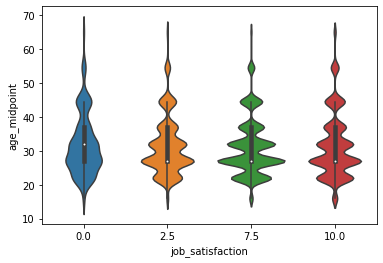

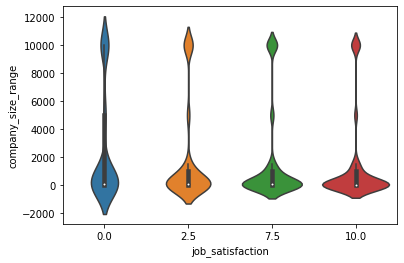

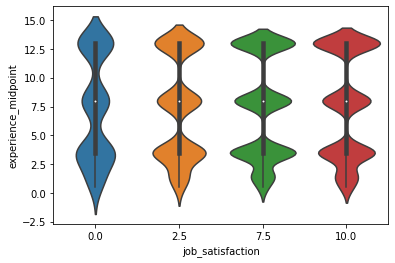

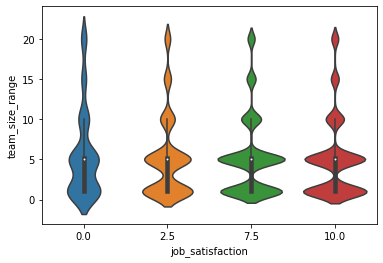

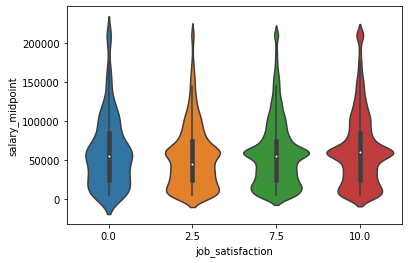

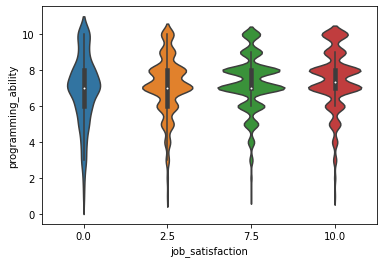

In [10]:
plt.figure()
sns.violinplot(x="job_satisfaction", y="age_midpoint", data=data, size=6)
plt.figure()
sns.violinplot(x="job_satisfaction", y="company_size_range", data=data, size=6)
plt.figure()
sns.violinplot(x="job_satisfaction", y="experience_midpoint", data=data, size=6)
plt.figure()
sns.violinplot(x="job_satisfaction", y="team_size_range", data=data, size=6)
plt.figure()
sns.violinplot(x="job_satisfaction", y="salary_midpoint", data=data, size=6)
plt.figure()
sns.violinplot(x="job_satisfaction", y="programming_ability", data=data, size=6)

## PCA

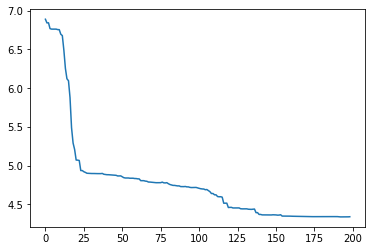

In [11]:
pca = PCA()
x_pca = pca.fit_transform(data.drop("job_satisfaction",1))

x_train, x_test, y_train, y_test = train_test_split(x_pca, data.job_satisfaction, test_size=0.30, random_state=43)

mse_rid = []
model = RidgeCV(alphas=[0.0001, 0.00021, 0.3333, 0.5, .00001, 0.59, 1, 5, 100, 1000, 10000, 99999, 100000])
for i in range(1,200):
    fit = model.fit(x_train[:,:i], y_train)
    x_sub = x_test[:,:i]
    lin_incpt_pred = fit.predict(x_sub)
    mse_rid.append(mean_squared_error(y_test, lin_incpt_pred))
plt.plot(mse_rid)

In [8]:
num_feats = 160
model = RidgeCV(alphas=[0.0001, 0.00021, 0.3333, 0.5, .00001, 0.59, 1, 5, 100, 1000, 10000, 99999, 100000])

x_train, x_test, y_train, y_test = train_test_split(x_pca, data.job_satisfaction, test_size=0.30, random_state=43)
fit = model.fit(x_train[:,:num_feats], y_train)
pred = fit.predict(x_test[:,:num_feats])
print(mean_squared_error(y_test, pred))

plt.figure()
confusion_matrix(y_test, pred)

4.347465049057561


ValueError: continuous is not supported

<Figure size 432x288 with 0 Axes>

## XGB

In [12]:
pla = [0,2.5,5,7.5,10]
def arr(pred):
    pred_bin = []
    for i in pred:
        if i >= 8.75:
            pred_bin.append("10.0")
        elif i < 8.75 and i >= 6.25:
            pred_bin.append("7.5")
        elif i < 6.25 and i >= 3.75:
            pred_bin.append("5.0")
        elif i < 3.75 and i >= 1.25:
            pred_bin.append("2.5")
        else:
            pred_bin.append("0.0")
    return pred_bin

def confmat(y_test, pred):
    pred_bin = arr(pred.astype('float'))
    y_test_bin = arr(y_test.astype('float'))

    labels = ['0.0', '2.5', '5.0', '7.5', '10.0']
    cm = confusion_matrix(y_test_bin,pred_bin, labels=labels)
    cm = pd.DataFrame(cm, columns=labels, index=labels)
    sns.heatmap(cm,annot=True,fmt="d", xticklabels=True, yticklabels=True)
    plt.show()



In [13]:
x_train, x_test, y_train, y_test = train_test_split(data.drop("job_satisfaction",1), data.job_satisfaction, test_size=0.30, random_state=43)

# model = XGBRegressor(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  nthread=7,
#  scale_pos_weight=1,
#  seed=43)

# fit = model.fit(x_train, y_train)
# pred = fit.predict(x_test)

# print(mean_squared_error(y_test, pred))

# plt.figure()
# plot_importance(model, max_num_features=10)

# plt.figure()
# confmat(y_test, pred)

12.467396295885404


<Figure size 432x288 with 0 Axes>

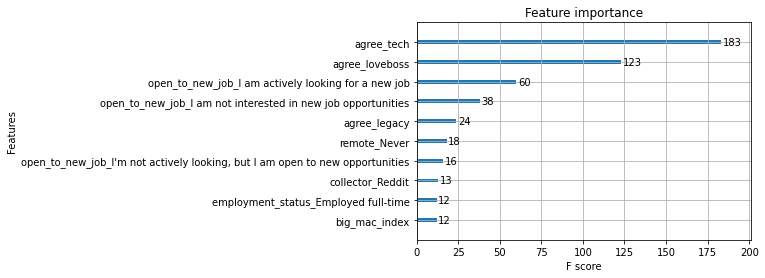

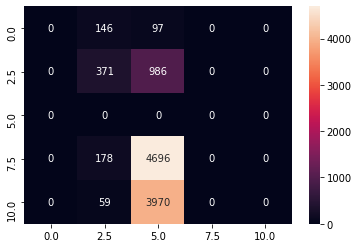

In [14]:
model = XGBRegressor(
    max_depth=4,
    min_child_weight=7,
    gamma=0,
    n_estimators=100, # todo 1500
    subsample=0.8,
    colsample_bytree=0.6,
    scale_pos_weight=1,
    reg_alpha=1,
    reg_lambda=100,
    n_jobs=-1,
    learning_rate=0.01)

fit = model.fit(x_train, y_train)
pred = fit.predict(x_test)

print(mean_squared_error(y_test, pred))

plt.figure()
plot_importance(model, max_num_features=10)
plt.show()

plt.figure()
confmat(y_test, pred)
plt.show()

In [16]:
params_test = {
    'learning_rate': [0.05],
    'n_estimators': [100], #todo 1000
    'max_depth': [5],
    'min_child_weight': [1],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [1],
    'seed': [43]
}
gsearch = GridSearchCV(XGBRegressor(), param_grid=params_test, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# gsearch.fit(x_train, y_train)
# gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

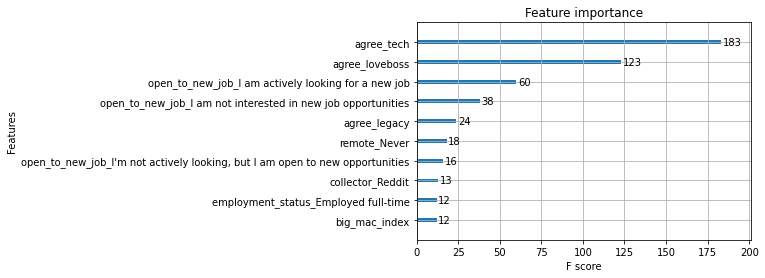

In [17]:
plot_importance(model, max_num_features=10)

In [18]:
print(list(data))

['age_midpoint', 'experience_midpoint', 'salary_midpoint', 'big_mac_index', 'programming_ability', 'company_size_range', 'team_size_range', 'women_on_team', 'job_satisfaction', 'hobby', 'rep_range', 'interview_likelihood', 'agree_tech', 'agree_notice', 'agree_problemsolving', 'agree_diversity', 'agree_adblocker', 'agree_alcohol', 'agree_loveboss', 'agree_nightcode', 'agree_legacy', 'agree_mars', 'important_variety', 'important_control', 'important_sameend', 'important_newtech', 'important_buildnew', 'important_buildexisting', 'important_promotion', 'important_companymission', 'important_wfh', 'important_ownoffice', 'gender_M', 'gender_F', 'self_identification_Manager', 'self_identification_Full Stack Overflow Developer', 'self_identification_Engineer', 'self_identification_Developer', 'self_identification_Full-stack Developer', 'self_identification_Hacker', 'self_identification_Guru', 'self_identification_Programmer', 'self_identification_Rockstar', 'self_identification_Sr. Developer',

In [19]:
data_4 = data[["agree_loveboss", "agree_tech", "open_to_new_job_I am actively looking for a new job", "interview_likelihood"]]
data_4.head()
x_train, x_test, y_train, y_test = train_test_split(data_4, data.job_satisfaction, test_size=0.30, random_state=43)
model = XGBRegressor(
    max_depth=3,
    min_child_weight=1,
    gamma=0.6,
    n_estimators=100, # todo 1500
    subsample=0.55,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    reg_alpha=1,
    reg_lambda=100,
    n_jobs=-1,
    learning_rate=0.0057)

fit = model.fit(x_train, y_train)
XGBRegressor.fit(x_test, y_test)
XGBRegressor.save_model(model, fname='output201X.model')
pred = fit.predict(x_test)

print(mean_squared_error(y_test, pred)**0.5)

plt.figure()
plot_importance(model, max_num_features=10)
plt.show()

plt.figure()
confmat(y_test, pred)
plt.show()

TypeError: fit() missing 1 required positional argument: 'y'

## StackNet<br>
From https://github.com/kaz-Anova/StackNet 

In [21]:
# x_train_pca = pd.DataFrame(x_train[:,:num_feats])
# y_train_pca = pd.DataFrame(y_train).reset_index().drop("index",1)
# x_test_pca = pd.DataFrame(x_test[:,:num_feats])
# y_test_pca = pd.DataFrame(y_test).reset_index().drop("index",1)
# train_new = pd.concat([y_train_pca, x_train_pca], 1)
# test_new = pd.concat([y_test_pca, x_test_pca], 1)
# train_new.to_csv("data/trainSN_2016.csv", index = False)
# test_new.to_csv("data/testSN_2016.csv", index = False)

TypeError: '(slice(None, None, None), slice(None, 160, None))' is an invalid key

First Layer:<br>
LogisticRegression Type:Liblinear C:2.0 threads:1 usescale:True maxim_Iteration:100 seed:1 verbose:false
GradientBoostingForestRegressor rounding:6 estimators:1000 shrinkage:0.1 offset:0.00001 max_tree_size:-1 cut_off_subsample:1.0 max_depth:8 max_features:0.4 min_leaf:4.0 min_split:8.0 Objective:RMSE row_subsample:0.7 seed:1 threads:1 bags:1 verbose:false<br>
RandomForestRegressor bootsrap:false max_tree_size:-1 cut_off_subsample:1.0 feature_subselection:1.0 rounding:6 estimators:100 offset:0.00001 max_depth:6 max_features:0.4 min_leaf:2.0 min_split:5.0 Objective:RMSE row_subsample:0.95 seed:1 threads:1 bags:1 verbose:false<br>
multinnregressor usescale:True maxim_Iteration:50 Objective:RMSE tau:0.5 UseConstant:true C:0.000001 shuffle:true tolerance:0.01 learn_rate:0.01 smooth:0.1 h1:20 h2:20 connection_nonlinearity:Relu init_values:0.02 seed:1 threads:1 bags:1 verbose:false<br>
LibFmRegressor maxim_Iteration:30 C:0.00001 C2:0.01 lfeatures:2 seed:1 usescale:True init_values:0.1 learn_rate:0.03 smooth:10.1 verbose:false<br>
GradientBoostingForestRegressor rounding:3 estimators:300 shrinkage:0.16 threads:1 cut_off_subsample:0.9 offset:0.1 max_depth:6 max_features:0.5 min_leaf:1.0 min_split:2.0 Objective:RMSE row_subsample:0.8 seed:1 verbose:false<br>
LinearRegression Type:Routine C:0.01 RegularizationType:L1 threads:1 usescale:True seed:1 verbose:false<br>
<br>
Second Layer:<br>
RandomForestRegressor rounding:12 estimators:1500 threads:5 max_depth:6 max_features:0.2 min_leaf:1.0 min_split:2.0 Objective:RMSE seed:1 verbose:false<br>
<br>
Resulted in RMSE: 3.167

In [ ]:
# data contains a DataFrame with no NaNs, all numbers.
# We're trying to predict the "job_satisfaction" column.